## 内容说明

1. 提取图片 ORB 描述子，得到描述子集合
2. 基于描述子集合，聚类构造字典
3. 在线检测图片的相似性：采用 seqslam 的思想，对比图片序列的相似性。
   具体实施：每个图片到来，连同之前的 10 幅图片一起，计算 seqVLAD，一方面存储起来，一方面对比之前所有的 seqVLAD，找到相似性最高的 seqVLAD。暂定为回环点，将相似性值保存起来，以备 PR curve 画图
4. 速度记录：随着历史图片的增多，搜索时间的变化趋势。横坐标是历史图片数量，纵坐标是搜索花费时间。

In [ ]:
import cv2
import numpy as np
import glob
import itertools
import pickle
from sklearn.cluster import KMeans
from numpy.linalg import norm
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import time

### 1. Extract ORB descriptors

In [2]:
def describeORB(image):
    orb=cv2.ORB_create()
    kp, des=orb.detectAndCompute(image,None)
    return kp,des

In [3]:
path = 'citycentre/Images'   # 2146 images
descriptors = []

for imagePath in sorted(glob.glob(path+"/*.jpg")):
    #print(imagePath)
    im=cv2.imread(imagePath)
    kp,des = describeORB(im)
    descriptors.append(des)

In [4]:
#flatten list       
descriptors = list(itertools.chain.from_iterable(descriptors))
#list to array
descriptors = np.asarray(descriptors)

In [5]:
#save the descriptors
desc_file="citycentre/0_descriptors.pickle"

with open(desc_file, 'wb') as f:
    pickle.dump(descriptors, f)

### 2. Build dictionary based on descriptors

In [6]:
# load the pickle file
desc_file="citycentre/0_descriptors.pickle"

with open(desc_file, 'rb') as f:
    descriptors = pickle.load(f)

In [7]:
# build dictionary by KMeans algorithm
k = 64
visualDictionary = KMeans(n_clusters=k,init='k-means++',tol=0.0001).fit(descriptors)

In [8]:
# save the dictionary
dict_file="citycentre/1_dictionary.pickle"

with open(dict_file, 'wb') as f:
    pickle.dump(visualDictionary, f)

### 3. Compute VLAD for each query image and match image sequence

维护渐增一个 vlad 列表. 

当图片来了之后，先计算它的 vlad，然后跟前边 10 个 vlad 组合出 seqvlad

对于普通的 seqslam，要逐个计算两个 seqvlad 之间的差距，选出最小的一个（idx, min_value）,留着画 PR 曲线用

对于HNSW seqslam，逐步添加 seqvlad 构造 HNSW，并且搜索最近邻，选出最小的一个（idx, min_value）,留着画 PR 曲线用

In [4]:
dict_file="citycentre/1_dictionary.pickle"

with open(dict_file, 'rb') as f:
    visualDictionary = pickle.load(f)

In [9]:
def VLAD(X,visualDictionary):
    
    # number of clusters: 64
    k=visualDictionary.n_clusters
    
    # 64 center vectors
    centers = visualDictionary.cluster_centers_
    
    # predicted labels for the query descriptor set X 
    predictedLabels = visualDictionary.predict(X)
   
    # 500 * 32 = 500 desc for each image  *  length of each ORB desc
    _, d = X.shape
    
    # init VLAD by zeros.
    V=np.zeros([k,d])

    # for all the clusters
    for i in range(k):
        # if there is at least one descriptor in that cluster
        if i in predictedLabels:
            # add the residuals
            V[i]=np.sum(X[predictedLabels==i,:]-centers[i],axis=0)
    

    # flatten the VLAD matrix to a vector
    V = V.flatten()
    
    # power normalization, also called square-rooting normalization
    V = np.sign(V)*np.sqrt(np.abs(V))

    # L2 normalization
    V = V/np.sqrt(np.dot(V,V))
    
    # return VLAD as a vector
    return V

In [10]:
def distance(seq1, seq2):
    dist = np.array(seq1) - np.array(seq2)
    dist_norm = norm(dist, axis=1)
    dist_sum = sum(dist_norm)   
    return dist_sum

In [11]:
path = 'citycentre/Images'

# only consider images on one side
imagePaths = sorted(glob.glob(path+"/*.jpg"))[::2]

image_num = len(imagePaths)
matches = np.nan * np.ones([image_num, 2])

vlad_history = []
timing = []

for index, imagePath in enumerate(imagePaths):
    print('image: ', imagePath)
    print('index: ', index)
    im=cv2.imread(imagePath)
    kp,des = describeORB(im)
    
    # for each image, compute VLAD
    vlad = VLAD(des,visualDictionary)
    
    # add current vlad to hisroty seq
    vlad_history.append(vlad) 
    
    # detection start from 100 frame
    if index >= 100:     

        vlad_seq_query = vlad_history[index-9:index+1]
        min_dist = np.inf
        min_index = None
        
        # 只对核心搜索过程计时
        # start timing
        t1 = time.time()
        
        # only search (9, index-10)
        for i in range(9, index-10):
            vlad_seq_search = vlad_history[i-9:i+1]
            dist = distance(vlad_seq_query, vlad_seq_search)
            if dist < min_dist:
                min_dist = dist
                min_index = i
        # end timing
        t2 = time.time()
        timing.append([index, t2-t1])
        
        matches[index, 0] = min_index
        matches[index, 1] = min_dist
        print("matches: ", matches[index,:])           
        
            


image:  citycentre/Images/0001.jpg
index:  0
image:  citycentre/Images/0003.jpg
index:  1
image:  citycentre/Images/0005.jpg
index:  2
image:  citycentre/Images/0007.jpg
index:  3
image:  citycentre/Images/0009.jpg
index:  4
image:  citycentre/Images/0011.jpg
index:  5
image:  citycentre/Images/0013.jpg
index:  6
image:  citycentre/Images/0015.jpg
index:  7
image:  citycentre/Images/0017.jpg
index:  8
image:  citycentre/Images/0019.jpg
index:  9
image:  citycentre/Images/0021.jpg
index:  10
image:  citycentre/Images/0023.jpg
index:  11
image:  citycentre/Images/0025.jpg
index:  12
image:  citycentre/Images/0027.jpg
index:  13
image:  citycentre/Images/0029.jpg
index:  14
image:  citycentre/Images/0031.jpg
index:  15
image:  citycentre/Images/0033.jpg
index:  16
image:  citycentre/Images/0035.jpg
index:  17
image:  citycentre/Images/0037.jpg
index:  18
image:  citycentre/Images/0039.jpg
index:  19
image:  citycentre/Images/0041.jpg
index:  20
image:  citycentre/Images/0043.jpg
index:  2

In [12]:
vlad_file = "citycentre/2_VLADs.pickle"

with open(vlad_file, 'wb') as f:
    pickle.dump(vlad_history, f)

In [13]:
matches_file = "citycentre/3_matches.pickle"

with open(matches_file, 'wb') as f:
    pickle.dump(matches, f)

In [14]:
matches_file = "citycentre/3_matches.pickle"

with open(matches_file, 'rb') as f:
    matches = pickle.load(f)

In [14]:
matches

array([[          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       ...,
       [  19.        ,   13.80410586],
       [1213.        ,   13.80811338],
       [1214.        ,   13.79902449]])

In [15]:
matches[:,1] = matches[:,1] / np.nanmax(matches[:,1])
matches

array([[           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       ...,
       [1.90000000e+01, 9.86579026e-01],
       [1.21300000e+03, 9.86865444e-01],
       [1.21400000e+03, 9.86215861e-01]])

In [16]:
matches_norm_file = "citycentre/3_matches_norm.pickle"

with open(matches_norm_file, 'wb') as f:
    pickle.dump(matches, f)

### 4. Evaluation the matches by PR curve

In [17]:
# load GT matrix
groundtruthPath = 'citycentre/CityCentreGroundTruth.mat'
groundtruthMat = loadmat(groundtruthPath)
groundtruthMat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Apr 10 19:02:54 2008',
 '__version__': '1.0',
 '__globals__': [],
 'truth': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [18]:
# extract right view
groundtruthMat = groundtruthMat['truth'][::2,::2]
groundtruthMat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
# 上述 gt 中还是存在一行中连续多列为 1，即一幅图片还可能与多幅邻近的图片匹配，在计算 positive 时不能直接累加，否则 recall 会很低
gt_loop = np.count_nonzero(np.sum(groundtruthMat, 1))
pr = []
row = matches.shape[0]

for mu in np.arange(0, 1, 0.01):
    idx = np.copy(matches[:, 0])  # The LARGER the score, the WEAKER the match.
    idx[matches[:, 1] > mu] = np.nan  # remove the weakest matches

    loopMat = np.zeros((row, row))
    for i in range(row):
        if not np.isnan(idx[i]):
            loopMat[i, int(idx[i])] = 1

    p_loop = np.sum(loopMat)
    TP = np.sum(loopMat * groundtruthMat)
    print('TP, p_loop: ', TP, p_loop)
    if p_loop != 0:
        pre = TP / p_loop
        rec = TP / gt_loop
        pr.append([pre, rec])

pr = np.array(pr)

TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  0.0 0.0
TP, p_loop:  

19


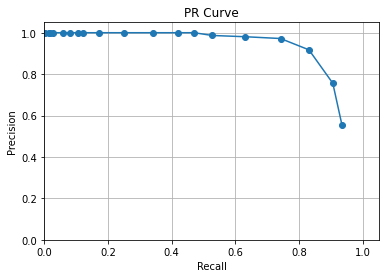

In [20]:
# plt.subplots() is recommended by matplotlib
fig, ax = plt.subplots()
ax.plot(pr[:, 1], pr[:, 0], '-o')
print(len(pr))
ax.set_title('PR Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
plt.axis([0, 1.05, 0, 1.05])
plt.show()

In [21]:
PR_curve_file = "citycentre/4_PR_curve.pickle"

with open(PR_curve_file, 'wb') as f:
    pickle.dump(pr, f)

### 5. Timing of seq search

In [ ]:
timing_array = np.array(timing)

In [ ]:
timing_array

array([[1.        , 0.00356506],
       [1.        , 0.01426025],
       [1.        , 0.01960784],
       [1.        , 0.0285205 ],
       [1.        , 0.06060606],
       [1.        , 0.0802139 ],
       [1.        , 0.10695187],
       [1.        , 0.12121212],
       [1.        , 0.17112299],
       [1.        , 0.24955437],
       [1.        , 0.34046346],
       [1.        , 0.42067736],
       [1.        , 0.47058824],
       [0.98666667, 0.52762923],
       [0.98060942, 0.63101604],
       [0.97196262, 0.74153298],
       [0.91732283, 0.83065954],
       [0.75595238, 0.90552585],
       [0.55567338, 0.93404635]])

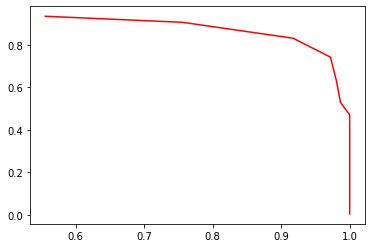

In [ ]:
plt.plot(timing_array[::150,0], timing_array[::150,1], 'r-')

In [25]:
timing_file = "citycentre/5_timing.pickle"

with open(timing_file, 'wb') as f:
    pickle.dump(timing_array, f)